In [5]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from cadet import Cadet
Cadet.cadet_path = '/Users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

In [6]:
n_comp = 1
tau = 1
V = 1

# Setting up the model
model = Cadet()
model.root.input.model.nunits = 3

# Example 1: Continuous stirred-tank reactor

In [7]:
# Unit operations
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
model.root.input.model.unit_001.unit_type = 'CSTR'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.init_volume = V
model.root.input.model.unit_001.init_c = [0.0]

# Outlet
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = n_comp

# Connections
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, V/tau,
    1, 2, -1, -1, V/tau,
]

## Pulse experiment CSTR

In [21]:
# Auxiliary variable
step_size = 1e-3

## Sections and Switches
model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, step_size, 10]
model.root.input.solver.sections.section_continuity = [0,]
model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)

# Create pulse
model.root.input.model.unit_000.sec_000.const_coeff = [1/step_size,]
model.root.input.model.unit_000.sec_001.const_coeff = [0.0,]


In [22]:
model.root.input.model.solver.gs_type = 1
model.root.input.model.solver.max_krylov = 0
model.root.input.model.solver.max_restarts = 10
model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
model.root.input.solver.time_integrator.abstol = 1e-6
model.root.input.solver.time_integrator.algtol = 1e-10
model.root.input.solver.time_integrator.reltol = 1e-6
model.root.input.solver.time_integrator.init_step_size = 1e-6
model.root.input.solver.time_integrator.max_steps = 1000000

In [23]:
# Return data
model.root.input['return'].split_components_data = 0
model.root.input['return'].split_ports_data = 0
model.root.input['return'].unit_000.write_solution_bulk = 1
model.root.input['return'].unit_000.write_solution_inlet = 1
model.root.input['return'].unit_000.write_solution_outlet = 1

# Copy settings to the other unit operations
model.root.input['return'].unit_001 = model.root.input['return'].unit_000

In [24]:
# Running simulation
model.filename = 'rtd-cstr.h5'
model.save()

data = model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


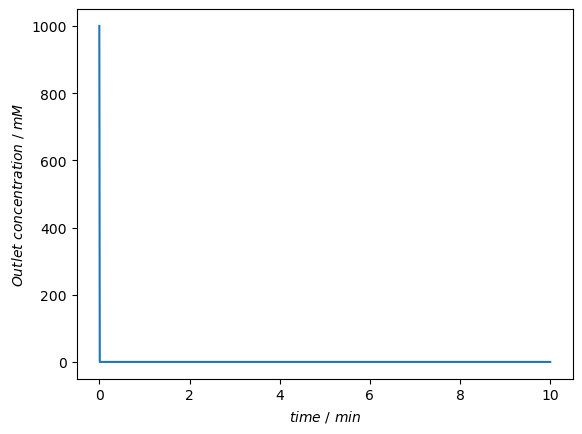

In [25]:
# Plotting the results of the inlet
plt.figure()
time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_inlet
plt.plot(time, c)
plt.xlabel('$time~/~min$')
plt.ylabel('$Outlet~concentration~/~mM$')
plt.show()

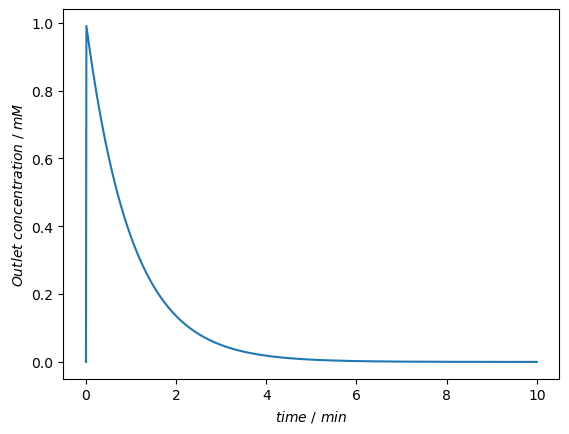

In [26]:
plt.figure()
time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.xlabel('$time~/~min$')
plt.ylabel('$Outlet~concentration~/~mM$')
plt.show()

# Example 2: Plug flow reactor

## PFR model

Although in CADET there is no explicit implementation of the PFR model, we can still model this reactor if we use any of the column models and set the porosity to 1 and the axial dispersion to 0.

In this example, we will use the `LUMPED_RATE_MODEL_WITHOUT_PORES`. For the model equations see [here](https://cadet.github.io/master/modelling/unit_operations/lumped_rate_model_without_pores.html) and the parameters [here](https://cadet.github.io/master/interface/unit_operations/lumped_rate_model_without_pores.html). The following parameters need to be specified:

- Column length `col_length`
- Interstitial velocity `velocity`
- Total porosity `total_porosity`
- Axial dispersion `col_dispersion`
- Initial concentration `init_c`

<div class="alert alert-info">

**Note:** 

As an alternative to the interstitial velocity, it is also possible to specify the cross section area of the column.

</div>

In [27]:
n_comp = 1
tau = 5
length = 1

model = Cadet()
model.root.input.model.nunits = 3

In [48]:
# Unit operations
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# Tubular reactor
model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.col_length = length
model.root.input.model.unit_001.velocity = length/tau
model.root.input.model.unit_001.total_porosity = 1
model.root.input.model.unit_001.col_dispersion = 0
model.root.input.model.unit_001.init_c = [0.0]

# Adsorption model
model.root.input.model.unit_001.adsorption_model = 'NONE'

# Outlet
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = n_comp

# Connections
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1,
    1, 2, -1, -1, 1,
]

In [49]:
# Discretization
# Grid cells
model.root.input.model.unit_001.discretization.ncol = 100

# Bound states
model.root.input.model.unit_001.discretization.nbound = n_comp*[0.0]

# Other options
model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
model.root.input.model.unit_001.discretization.gs_type = 1
model.root.input.model.unit_001.discretization.max_krylov = 0
model.root.input.model.unit_001.discretization.max_restarts = 10
model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

# Weno options
model.root.input.model.unit_001.discretization.weno.boundary_model = 0
model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
model.root.input.model.unit_001.discretization.weno.weno_order = 3

### Create pulse and run simulation

In [50]:
# Auxiliary variable
step_size = 1e-3

## Sections and Switches
model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, step_size, 10]
model.root.input.solver.sections.section_continuity = [0,]
model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)

# Create pulse
model.root.input.model.unit_000.sec_000.const_coeff = [1/step_size,]
model.root.input.model.unit_000.sec_001.const_coeff = [0.0,]

In [51]:
model.root.input.model.solver.gs_type = 1
model.root.input.model.solver.max_krylov = 0
model.root.input.model.solver.max_restarts = 10
model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
model.root.input.solver.time_integrator.abstol = 1e-6
model.root.input.solver.time_integrator.algtol = 1e-10
model.root.input.solver.time_integrator.reltol = 1e-6
model.root.input.solver.time_integrator.init_step_size = 1e-6
model.root.input.solver.time_integrator.max_steps = 1000000

In [52]:
# Return data
model.root.input['return'].split_components_data = 0
model.root.input['return'].split_ports_data = 0
model.root.input['return'].unit_000.write_solution_bulk = 1
model.root.input['return'].unit_000.write_solution_inlet = 1
model.root.input['return'].unit_000.write_solution_outlet = 1

# Copy settings to the other unit operations
model.root.input['return'].unit_001 = model.root.input['return'].unit_000

In [53]:
# Running simulation
model.filename = 'rtd-pfr.h5'
model.save()

data = model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


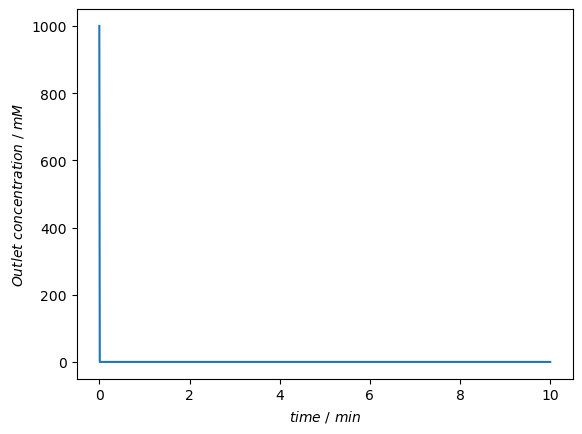

In [54]:
# Plotting the results of the inlet
plt.figure()
time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_inlet
plt.plot(time, c)
plt.xlabel('$time~/~min$')
plt.ylabel('$Outlet~concentration~/~mM$')
plt.show()

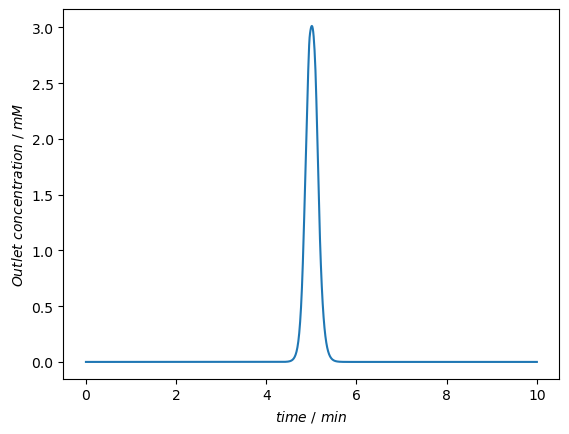

In [55]:
plt.figure()
time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.xlabel('$time~/~min$')
plt.ylabel('$Outlet~concentration~/~mM$')
plt.show()